# notes

1. Had to use nightly build of pudl db cos stable build did not have core_eia860__scd_generators_energy_storage table
2. duckdb
3. eia_ads_generator_mapping_updated.csv

In [1]:
import pandas as pd
import sqlite3

In [2]:
# mapping of columns in the Excel sheets to the PUDL database

gen_cols_mapping = [
    'plant_code', # -> plant_id_eia
    'plant_name', # -> plant_name_eia
    'generator_id',
    'operating_year', # -> generator_operating_date
    'nameplate_capacity_mw', # -> capacity_mw
    'summer_capacity_mw',
    'winter_capacity_mw',
    'minimum_load_mw',
    'energy_source_1', # -> energy_source_code_1
    'technology', # -> technology_description
    'status', # -> operational_status_code
    'prime_mover', # -> prime_mover_code
    'operating_month', # -> generator_operating_date
    'operating_year', # -> generator_operating_date
    'planned_retirement_month', # -> planned_generator_retirement_date
    'planned_retirement_year', # -> planned_generator_retirement_date
    'state',
    ]

storage_cols_mapping = [
    'plant_code', # -> plant_id_eia
    'generator_id',
    'nameplate_energy_capacity_mwh', # -> energy_storage_capacity_mwh
    'maximum_charge_rate_mw', # -> max_charge_rate_mw
    'maximum_discharge_rate_mw', # -> max_discharge_rate_mw
    'storage_technology_1'] # -> storage_technology_code_1

locs_cols_mapping = [
    'plant_code', # -> plant_id_eia
    'nerc_region',
    'balancing_authority_code', # -> balancing_authority_code_eia
    'latitude',
    'longitude']

con = sqlite3.connect("/home/stephen/Downloads/pudl.sqlite(1)/pudl.sqlite")

cur = con.cursor()

res = cur.execute("""SELECT m.name as tableName,
       p.name as columnName
FROM sqlite_master m
left outer join pragma_table_info((m.name)) p
     on m.name <> p.name
order by tableName, columnName""")

table_cols = res.fetchall()



In [3]:
for table, col in table_cols:
    if 'storage' in table:
        print(table, col)

core_eia860__scd_generators_energy_storage generator_id
core_eia860__scd_generators_energy_storage max_charge_rate_mw
core_eia860__scd_generators_energy_storage max_discharge_rate_mw
core_eia860__scd_generators_energy_storage plant_id_eia
core_eia860__scd_generators_energy_storage report_date
core_eia860__scd_generators_energy_storage served_arbitrage
core_eia860__scd_generators_energy_storage served_backup_power
core_eia860__scd_generators_energy_storage served_co_located_renewable_firming
core_eia860__scd_generators_energy_storage served_frequency_regulation
core_eia860__scd_generators_energy_storage served_load_following
core_eia860__scd_generators_energy_storage served_load_management
core_eia860__scd_generators_energy_storage served_ramping_spinning_reserve
core_eia860__scd_generators_energy_storage served_system_peak_shaving
core_eia860__scd_generators_energy_storage served_transmission_and_distribution_deferral
core_eia860__scd_generators_energy_storage served_voltage_or_reactiv

In [4]:
# eia_data_operable = pd.read_sql_query(
#     """
#     SELECT
#         out_eia__yearly_generators.plant_id_eia,
#         out_eia__yearly_generators.plant_name_eia,
#         out_eia__yearly_generators.generator_id,
#         out_eia__yearly_generators.capacity_mw,
#         out_eia__yearly_generators.summer_capacity_mw,
#         out_eia__yearly_generators.winter_capacity_mw,
#         out_eia__yearly_generators.minimum_load_mw,
#         out_eia__yearly_generators.energy_source_code_1,
#         out_eia__yearly_generators.technology_description,
#         out_eia__yearly_generators.operational_status,
#         out_eia__yearly_generators.prime_mover_code,
#         out_eia__yearly_generators.planned_generator_retirement_date,
#         out_eia__yearly_generators.energy_storage_capacity_mwh,
#         out_eia__yearly_generators.generator_operating_date,
#         core_eia860__scd_generators_energy_storage.max_charge_rate_mw,
#         core_eia860__scd_generators_energy_storage.max_discharge_rate_mw,
#         core_eia860__scd_generators_energy_storage.storage_technology_code_1,
#         core_eia860__scd_plants.nerc_region,
#         core_eia860__scd_plants.balancing_authority_code_eia,
#         out_eia__yearly_generators.state,
#         out_eia__yearly_generators.latitude,
#         out_eia__yearly_generators.longitude
#     FROM out_eia__yearly_generators
#     LEFT JOIN core_eia860__scd_generators_energy_storage ON out_eia__yearly_generators.plant_id_eia = core_eia860__scd_generators_energy_storage.plant_id_eia AND out_eia__yearly_generators.generator_id = core_eia860__scd_generators_energy_storage.generator_id
#     LEFT JOIN core_eia860__scd_plants ON out_eia__yearly_generators.plant_id_eia = core_eia860__scd_plants.plant_id_eia
#     WHERE out_eia__yearly_generators.operational_status = 'existing'
#     -- GROUP BY out_eia__yearly_generators.plant_id_eia, out_eia__yearly_generators.generator_id
#     -- HAVING MAX(out_eia__yearly_generators.report_date)
#     -- ORDER BY out_eia__yearly_generators.report_date DESC
#     """,
#     con,
# )


In [5]:
import duckdb

con_duck = duckdb.connect(database=':memory:', read_only=False)

duckdb.query("INSTALL sqlite;")

In [6]:
duckdb.query(
    """
ATTACH '/home/stephen/Downloads/pudl.sqlite(1)/pudl.sqlite' (TYPE SQLITE);
USE pudl;
"""
)

In [7]:


eia_data_operable = duckdb.query(
    """
    WITH monthly_generators AS (
        SELECT
            plant_id_eia,
            generator_id,
            array_agg(out_eia__monthly_generators.unit_heat_rate_mmbtu_per_mwh ORDER BY out_eia__monthly_generators.report_date DESC) FILTER (WHERE out_eia__monthly_generators.unit_heat_rate_mmbtu_per_mwh IS NOT NULL)[1] AS unit_heat_rate_mmbtu_per_mwh
        FROM out_eia__monthly_generators
        WHERE operational_status = 'existing' AND report_date >= '2022-01-01'
        GROUP BY plant_id_eia, generator_id
    )
    SELECT
        out_eia__yearly_generators.plant_id_eia,
        out_eia__yearly_generators.generator_id,
        array_agg(out_eia__yearly_generators.plant_name_eia ORDER BY out_eia__yearly_generators.report_date DESC) FILTER (WHERE out_eia__yearly_generators.plant_name_eia IS NOT NULL)[1] AS plant_name_eia,
        array_agg(out_eia__yearly_generators.capacity_mw ORDER BY out_eia__yearly_generators.report_date DESC) FILTER (WHERE out_eia__yearly_generators.capacity_mw IS NOT NULL)[1] AS capacity_mw,
        array_agg(out_eia__yearly_generators.summer_capacity_mw ORDER BY out_eia__yearly_generators.report_date DESC) FILTER (WHERE out_eia__yearly_generators.summer_capacity_mw IS NOT NULL)[1] AS summer_capacity_mw,
        array_agg(out_eia__yearly_generators.winter_capacity_mw ORDER BY out_eia__yearly_generators.report_date DESC) FILTER (WHERE out_eia__yearly_generators.winter_capacity_mw IS NOT NULL)[1] AS winter_capacity_mw,
        array_agg(out_eia__yearly_generators.minimum_load_mw ORDER BY out_eia__yearly_generators.report_date DESC) FILTER (WHERE out_eia__yearly_generators.minimum_load_mw IS NOT NULL)[1] AS minimum_load_mw,
        array_agg(out_eia__yearly_generators.energy_source_code_1 ORDER BY out_eia__yearly_generators.report_date DESC) FILTER (WHERE out_eia__yearly_generators.energy_source_code_1 IS NOT NULL)[1] AS energy_source_code_1,
        array_agg(out_eia__yearly_generators.technology_description ORDER BY out_eia__yearly_generators.report_date DESC) FILTER (WHERE out_eia__yearly_generators.technology_description IS NOT NULL)[1] AS technology_description,
        arbitrary(out_eia__yearly_generators.operational_status) AS operational_status,
        array_agg(out_eia__yearly_generators.prime_mover_code ORDER BY out_eia__yearly_generators.report_date DESC) FILTER (WHERE out_eia__yearly_generators.prime_mover_code IS NOT NULL)[1] AS prime_mover_code,
        array_agg(out_eia__yearly_generators.planned_generator_retirement_date ORDER BY out_eia__yearly_generators.report_date DESC) FILTER (WHERE out_eia__yearly_generators.planned_generator_retirement_date IS NOT NULL)[1] AS planned_generator_retirement_date,
        array_agg(out_eia__yearly_generators.energy_storage_capacity_mwh ORDER BY out_eia__yearly_generators.report_date DESC) FILTER (WHERE out_eia__yearly_generators.energy_storage_capacity_mwh IS NOT NULL)[1] AS energy_storage_capacity_mwh,
        array_agg(out_eia__yearly_generators.generator_operating_date ORDER BY out_eia__yearly_generators.report_date DESC) FILTER (WHERE out_eia__yearly_generators.generator_operating_date IS NOT NULL)[1] AS generator_operating_date,
        array_agg(out_eia__yearly_generators.state ORDER BY out_eia__yearly_generators.report_date DESC) FILTER (WHERE out_eia__yearly_generators.state IS NOT NULL)[1] AS state,
        array_agg(out_eia__yearly_generators.latitude ORDER BY out_eia__yearly_generators.report_date DESC) FILTER (WHERE out_eia__yearly_generators.latitude IS NOT NULL)[1] AS latitude,
        array_agg(out_eia__yearly_generators.longitude ORDER BY out_eia__yearly_generators.report_date DESC) FILTER (WHERE out_eia__yearly_generators.longitude IS NOT NULL)[1] AS longitude,
        array_agg(core_eia860__scd_generators_energy_storage.max_charge_rate_mw ORDER BY core_eia860__scd_generators_energy_storage.report_date DESC) FILTER (WHERE core_eia860__scd_generators_energy_storage.max_charge_rate_mw IS NOT NULL)[1] AS max_charge_rate_mw,
        array_agg(core_eia860__scd_generators_energy_storage.max_discharge_rate_mw ORDER BY core_eia860__scd_generators_energy_storage.report_date DESC) FILTER (WHERE core_eia860__scd_generators_energy_storage.max_discharge_rate_mw IS NOT NULL)[1] AS max_discharge_rate_mw,
        array_agg(core_eia860__scd_generators_energy_storage.storage_technology_code_1 ORDER BY core_eia860__scd_generators_energy_storage.report_date DESC) FILTER (WHERE core_eia860__scd_generators_energy_storage.storage_technology_code_1 IS NOT NULL)[1] AS storage_technology_code_1,
        array_agg(core_eia860__scd_plants.nerc_region ORDER BY core_eia860__scd_plants.report_date DESC) FILTER (WHERE core_eia860__scd_plants.nerc_region IS NOT NULL)[1] AS nerc_region,
        array_agg(core_eia860__scd_plants.balancing_authority_code_eia ORDER BY core_eia860__scd_plants.report_date DESC) FILTER (WHERE core_eia860__scd_plants.balancing_authority_code_eia IS NOT NULL)[1] AS balancing_authority_code_eia,
        first(monthly_generators.unit_heat_rate_mmbtu_per_mwh) AS unit_heat_rate_mmbtu_per_mwh
    FROM out_eia__yearly_generators
    LEFT JOIN core_eia860__scd_generators_energy_storage ON out_eia__yearly_generators.plant_id_eia = core_eia860__scd_generators_energy_storage.plant_id_eia AND out_eia__yearly_generators.generator_id = core_eia860__scd_generators_energy_storage.generator_id
    LEFT JOIN core_eia860__scd_plants ON out_eia__yearly_generators.plant_id_eia = core_eia860__scd_plants.plant_id_eia
    LEFT JOIN monthly_generators ON out_eia__yearly_generators.plant_id_eia = monthly_generators.plant_id_eia AND out_eia__yearly_generators.generator_id = monthly_generators.generator_id
    WHERE out_eia__yearly_generators.operational_status = 'existing'
    GROUP BY out_eia__yearly_generators.plant_id_eia, out_eia__yearly_generators.generator_id
"""
).to_df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [8]:
eia_data_operable[eia_data_operable['plant_id_eia'] == 141]


plant_id_eia generator_id plant_name_eia  capacity_mw  \
1540            141          AF6      Agua Fria    71.199997   
5782            141          AF1      Agua Fria   113.599998   
5783            141          AF5      Agua Fria    71.199997   
14215           141          AF2      Agua Fria   113.599998   
14216           141         PV-3      Agua Fria     0.200000   
18446           141          AF4      Agua Fria    80.500000   
18447           141        AFSB1      Agua Fria    25.000000   
22756           141          AF7      Agua Fria    49.500000   
26954           141          AF8      Agua Fria    49.500000   
31152           141          AF3      Agua Fria   163.199997   

       summer_capacity_mw  winter_capacity_mw  minimum_load_mw  \
1540                 73.0                82.0             73.0   
5782                113.0               113.0            113.0   
5783                 73.0                82.0             73.0   
14215               113.0               113.0            113.0   
14216                 0.2                 0.2              0.2   
18446                73.0                87.0             73.0   
18447                25.0                25.0             25.0   
22756                49.5                49.5             23.0   
26954                49.5                49.5             23.0   
31152               181.0               184.0            181.0   

      energy_source_code_1                technology_description  \
1540                    NG  Natural Gas Fired Combustion Turbine   
5782                    NG             Natural Gas Steam Turbine   
5783                    NG  Natural Gas Fired Combustion Turbine   
14215                   NG             Natural Gas Steam Turbine   
14216                  SUN                    Solar Photovoltaic   
18446                   NG  Natural Gas Fired Combustion Turbine   
18447                  MWH                             Batteries   
22756                   NG  Natural Gas Fired Combustion Turbine   
26954                   NG  Natural Gas Fired Combustion Turbine   
31152                  DFO                     Petroleum Liquids   

      operational_status  ... generator_operating_date state   latitude  \
1540            existing  ...               1974-07-01    AZ  33.556099   
5782            existing  ...               1958-01-01    AZ  33.556099   
5783            existing  ...               1974-07-01    AZ  33.556099   
14215           existing  ...               1957-04-01    AZ  33.556099   
14216           existing  ...               2001-06-01    AZ  33.556099   
18446           existing  ...               1975-05-01    AZ  33.556099   
18447           existing  ...               2021-09-01    AZ  33.556099   
22756           existing  ...               2022-08-01    AZ  33.556099   
26954           existing  ...               2022-08-01    AZ  33.556099   
31152           existing  ...               1961-04-01    AZ  33.556099   

        longitude max_charge_rate_mw  max_discharge_rate_mw  \
1540  -112.215302                NaN                    NaN   
5782  -112.215302                NaN                    NaN   
5783  -112.215302                NaN                    NaN   
14215 -112.215302                NaN                    NaN   
14216 -112.215302                NaN                    NaN   
18446 -112.215302                NaN                    NaN   
18447 -112.215302               25.0                   25.0   
22756 -112.215302                NaN                    NaN   
26954 -112.215302                NaN                    NaN   
31152 -112.215302                NaN                    NaN   

       storage_technology_code_1  nerc_region  balancing_authority_code_eia  \
1540                        None         WECC                           SRP   
5782                        None         WECC                           SRP   
5783                        None         WECC                        

In [9]:
eia_data_operable.loc[eia_data_operable.state.isin(['AK', 'HI']), 'nerc_region'] = 'non-conus'
eia_data_operable.loc[eia_data_operable.state.isin(['AK', 'HI']), 'balancing_authority_code'] = 'non-conus'
eia_data_operable



plant_id_eia generator_id                          plant_name_eia  \
0               484            1                            Red Mountain   
1               492           A1                             South Plant   
2               492           A5                             South Plant   
3               494            3                         Manitou Springs   
4               507            4                              Las Animas   
...             ...          ...                                     ...   
33854         59792            4  Orchard Hills Renewable Energy Station   
33855         62361        USBRU                     USS Brude Solar CSG   
33856         62362        USEHW                 USS East Hauer Watt CSG   
33857         62447            2       South Nassau Communities Hospital   
33858         63435         BATT      Partridge Solar Project CSG Hybrid   

       capacity_mw  summer_capacity_mw  winter_capacity_mw  minimum_load_mw  \
0         5.900000                 5.9                 5.9              1.0   
1        40.900002                25.0                25.0              NaN   
2        40.900002                25.0                25.0              NaN   
3         0.600000                 0.5                 0.5              NaN   
4         1.000000                 1.0                 1.0              0.5   
...            ...                 ...                 ...              ...   
33854     2.700000                 2.2                 2.5              1.0   
33855     1.000000                 1.0                 1.0              NaN   
33856     1.000000                 1.0                 1.0              NaN   
33857     0.800000                 0.8                 0.8              NaN   
33858     1.300000                 1.3                 1.3              NaN   

      energy_source_code_1                technology_description  \
0                      WAT            Conventional Hydroelectric   
1                       NG  Natural Gas Fired Combustion Turbine   
2                       NG  Natural Gas Fired Combustion Turbine   
3                      WAT            Conventional Hydroelectric   
4                      DFO                     Petroleum Liquids   
...                    ...                                   ...   
33854                  LFG                          Landfill Gas   
33855                  SUN                    Solar Photovoltaic   
33856                  SUN                    Solar Photovoltaic   
33857                  DFO                     Petroleum Liquids   
33858                  MWH                             Batteries   

      operational_status  ... state   latitude   longitude max_charge_rate_mw  \
0               existing  ...    CA  33.394402 -117.188904                NaN   
1               existing  ...    CO  38.824444 -104.833336                NaN   
2               existing  ...    CO  38.824444 -104.833336                NaN   
3               existing  ...    CO  38.855556 -104.933060                NaN   
4               existing  ...    CO  38.064701 -103.220596                NaN   
...                  ...  ...   ...        ...         ...                ...   
33854           existing  ...    IL  42.142399  -89.079002                NaN   
33855           existing  ...    MN  44.094002  -94.057999                NaN   
33856           existing  ...    MN  44.652000  -93.497002                NaN   
33857           existing  ...    NY  40.651615  -73.629929                NaN   
33858           existing  ...    MA  42.118900  -71.937103                1.3   

      max_discharge_rate_mw  storage_technology_code_1  nerc_region  \
0                       NaN                       None         WECC   
1                       NaN                       None         WECC   
2                       NaN                       None         WECC   
3                       NaN                       None         WECC   


In [10]:
eia_data_operable['summer_derate'] = 1 - ((eia_data_operable.capacity_mw - eia_data_operable.summer_capacity_mw) / eia_data_operable.capacity_mw)
eia_data_operable['winter_derate'] = 1 - ((eia_data_operable.capacity_mw - eia_data_operable.winter_capacity_mw) / eia_data_operable.capacity_mw)
eia_data_operable.summer_derate = eia_data_operable.summer_derate.clip(upper=1).clip(lower=0)
eia_data_operable.winter_derate = eia_data_operable.winter_derate.clip(upper=1).clip(lower=0)
eia_data_operable


plant_id_eia generator_id                          plant_name_eia  \
0               484            1                            Red Mountain   
1               492           A1                             South Plant   
2               492           A5                             South Plant   
3               494            3                         Manitou Springs   
4               507            4                              Las Animas   
...             ...          ...                                     ...   
33854         59792            4  Orchard Hills Renewable Energy Station   
33855         62361        USBRU                     USS Brude Solar CSG   
33856         62362        USEHW                 USS East Hauer Watt CSG   
33857         62447            2       South Nassau Communities Hospital   
33858         63435         BATT      Partridge Solar Project CSG Hybrid   

       capacity_mw  summer_capacity_mw  winter_capacity_mw  minimum_load_mw  \
0         5.900000                 5.9                 5.9              1.0   
1        40.900002                25.0                25.0              NaN   
2        40.900002                25.0                25.0              NaN   
3         0.600000                 0.5                 0.5              NaN   
4         1.000000                 1.0                 1.0              0.5   
...            ...                 ...                 ...              ...   
33854     2.700000                 2.2                 2.5              1.0   
33855     1.000000                 1.0                 1.0              NaN   
33856     1.000000                 1.0                 1.0              NaN   
33857     0.800000                 0.8                 0.8              NaN   
33858     1.300000                 1.3                 1.3              NaN   

      energy_source_code_1                technology_description  \
0                      WAT            Conventional Hydroelectric   
1                       NG  Natural Gas Fired Combustion Turbine   
2                       NG  Natural Gas Fired Combustion Turbine   
3                      WAT            Conventional Hydroelectric   
4                      DFO                     Petroleum Liquids   
...                    ...                                   ...   
33854                  LFG                          Landfill Gas   
33855                  SUN                    Solar Photovoltaic   
33856                  SUN                    Solar Photovoltaic   
33857                  DFO                     Petroleum Liquids   
33858                  MWH                             Batteries   

      operational_status  ...   longitude max_charge_rate_mw  \
0               existing  ... -117.188904                NaN   
1               existing  ... -104.833336                NaN   
2               existing  ... -104.833336                NaN   
3               existing  ... -104.933060                NaN   
4               existing  ... -103.220596                NaN   
...                  ...  ...         ...                ...   
33854           existing  ...  -89.079002                NaN   
33855           existing  ...  -94.057999                NaN   
33856           existing  ...  -93.497002                NaN   
33857           existing  ...  -73.629929                NaN   
33858           existing  ...  -71.937103                1.3   

       max_discharge_rate_mw storage_technology_code_1 nerc_region  \
0                        NaN                      None        WECC   
1                        NaN                      None        WECC   
2                        NaN                      None        WECC   
3                        NaN                      None        WECC   
4                        NaN                      None        WECC   
...                      ...                       ...         ...   
33854                    NaN                      None         RFC   

In [11]:
# Assign PyPSA Carrier Names, Fuel Types, and Prime Movers Names
eia_tech_map = pd.DataFrame({
    "Technology": [
        "Petroleum Liquids",
        "Onshore Wind Turbine",
        "Conventional Hydroelectric",
        "Natural Gas Steam Turbine",
        "Conventional Steam Coal",
        "Natural Gas Fired Combined Cycle",
        "Natural Gas Fired Combustion Turbine",
        "Nuclear",
        "Hydroelectric Pumped Storage",
        "Natural Gas Internal Combustion Engine",
        "Solar Photovoltaic",
        "Geothermal",
        "Landfill Gas",
        "Batteries",
        "Wood/Wood Waste Biomass",
        "Coal Integrated Gasification Combined Cycle",
        "Other Gases",
        "Petroleum Coke",
        "Municipal Solid Waste",
        "Natural Gas with Compressed Air Storage",
        "All Other",
        "Other Waste Biomass",
        "Solar Thermal without Energy Storage",
        "Other Natural Gas",
        "Solar Thermal with Energy Storage",
        "Flywheels",
        "Offshore Wind Turbine",
    ],
    "tech_type": [
        "oil",
        "onwind",
        "hydro",
        "OCGT",
        "coal",
        "CCGT",
        "OCGT",
        "nuclear",
        "hydro",
        "OCGT",
        "solar",
        "geothermal",
        "biomass",
        "battery",
        "biomass",
        "coal",
        "other",
        "oil",
        "waste",
        "other",
        "other",
        "biomass",
        "solar",
        "other",
        "solar",
        "other",
        "offwind",
    ]
})
eia_tech_map.set_index("Technology", inplace=True)
eia_fuel_map = pd.DataFrame({
    "Energy Source 1": [
        "ANT",
        "BIT",
        "LIG",
        "SGC",
        "SUB",
        "WC",
        "RC",
        "DFO",
        "JF",
        "KER",
        "PC",
        "PG",
        "RFO",
        "SGP",
        "WO",
        "BFG",
        "NG",
        "H2",
        "OG",
        "AB",
        "MSW",
        "OBS",
        "WDS",
        "OBL",
        "SLW",
        "BLQ",
        "WDL",
        "LFG",
        "OBG",
        "SUN",
        "WND",
        "GEO",
        "WAT",
        "NUC",
        "PUR",
        "WH",
        "TDF",
        "MWH",
        "OTH",
    ],
    "fuel_type": [
        "coal",
        "coal",
        "coal",
        "coal",
        "coal",
        "coal",
        "coal",
        "oil",
        "oil",
        "oil",
        "oil",
        "oil",
        "oil",
        "oil",
        "oil",
        "gas",
        "gas",
        "gas",
        "gas",
        "waste",
        "waste",
        "waste",
        "waste",
        "biomass",
        "biomass",
        "biomass",
        "biomass",
        "biomass",
        "biomass",
        "solar",
        "wind",
        "geothermal",
        "hydro",
        "nuclear",
        "other",
        "other",
        "other",
        "other",
        "other",
    ],
    "fuel_name": [
        "Anthracite Coal",
        "Bituminous Coal",
        "Lignite Coal",
        "Coal-Derived Synthesis Gas",
        "Subbituminous Coal",
        "Waste/Other Coal",
        "Refined Coal",
        "Distillate Fuel Oil",
        "Jet Fuel",
        "Kerosene",
        "Petroleum Coke",
        "Gaseous Propane",
        "Residual Fuel Oil",
        "Synthesis Gas from Petroleum Coke",
        "Waste/Other Oil",
        "Blast Furnace Gas",
        "Natural Gas",
        "Hydrogen",
        "Other Gas",
        "Agricultural By-Products",
        "Municipal Solid Waste",
        "Other Biomass Solids",
        "Wood/Wood Waste Solids",
        "Other Biomass Liquids",
        "Sludge Waste",
        "Black Liquor",
        "Wood Waste Liquids excluding Black Liquor",
        "Landfill Gas",
        "Other Biomass Gas",
        "Solar",
        "Wind",
        "Geothermal",
        "Water",
        "Nuclear",
        "Purchased Steam",
        "Waste heat not directly attributed to a fuel source (undetermined)",
        "Tire-derived Fuels",
        "Energy Storage",
        "Other",
    ]
})
eia_fuel_map.set_index("Energy Source 1", inplace=True)
eia_primemover_map = pd.DataFrame({
    "Prime Mover": [
        "BA",
        "CE",
        "CP",
        "FW",
        "PS",
        "ES",
        "ST",
        "GT",
        "IC",
        "CA",
        "CT",
        "CS",
        "CC",
        "HA",
        "HB",
        "HK",
        "HY",
        "BT",
        "PV",
        "WT",
        "WS",
        "FC",
        "OT",
    ],
    "prime_mover": [
        "Energy Storage, Battery",
        "Energy Storage, Compressed Air",
        "Energy Storage, Concentrated Solar Power",
        "Energy Storage, Flywheel",
        "Energy Storage, Reversible Hydraulic Turbine (Pumped Storage)",
        "Energy Storage, Other",
        "Steam Turbine, including nuclear, geothermal and solar steam (does NOT include combined cycle)",
        "Combustion (Gas) Turbine",
        "Internal Combustion Engine",
        "Combined Cycle Steam Part",
        "Combined Cycle Combustion Turbine Part",
        "Combined Cycle Single Shaft",
        "Combined Cycle Total Unit (planned undetermined plants)",
        "Hydrokinetic, Axial Flow Turbine",
        "Hydrokinetic, Wave Buoy",
        "Hydrokinetic, Other",
        "Hydroelectric Turbine",
        "Turbines Used in a Binary Cycle (including those used for geothermal applications)",
        "Photovoltaic",
        "Wind Turbine, Onshore",
        "Wind Turbine, Offshore",
        "Fuel Cell",
        "Other",
    ]
})
eia_primemover_map.set_index("Prime Mover", inplace=True)

# Map technologies, fuels, and prime movers
maps = {
    "carrier": (eia_data_operable["technology_description"], eia_tech_map["tech_type"]),
    "fuel_type": (eia_data_operable["energy_source_code_1"], eia_fuel_map["fuel_type"]),
    "fuel_name": (eia_data_operable["energy_source_code_1"], eia_fuel_map["fuel_name"]),
    "prime_mover_name": (eia_data_operable["prime_mover_code"], eia_primemover_map["prime_mover"]),
}
for col, (data_col, map_df) in maps.items():
    eia_data_operable[col] = data_col.map(dict(zip(map_df.index, map_df.values)))

eia_data_operable

plant_id_eia generator_id                          plant_name_eia  \
0               484            1                            Red Mountain   
1               492           A1                             South Plant   
2               492           A5                             South Plant   
3               494            3                         Manitou Springs   
4               507            4                              Las Animas   
...             ...          ...                                     ...   
33854         59792            4  Orchard Hills Renewable Energy Station   
33855         62361        USBRU                     USS Brude Solar CSG   
33856         62362        USEHW                 USS East Hauer Watt CSG   
33857         62447            2       South Nassau Communities Hospital   
33858         63435         BATT      Partridge Solar Project CSG Hybrid   

       capacity_mw  summer_capacity_mw  winter_capacity_mw  minimum_load_mw  \
0         5.900000                 5.9                 5.9              1.0   
1        40.900002                25.0                25.0              NaN   
2        40.900002                25.0                25.0              NaN   
3         0.600000                 0.5                 0.5              NaN   
4         1.000000                 1.0                 1.0              0.5   
...            ...                 ...                 ...              ...   
33854     2.700000                 2.2                 2.5              1.0   
33855     1.000000                 1.0                 1.0              NaN   
33856     1.000000                 1.0                 1.0              NaN   
33857     0.800000                 0.8                 0.8              NaN   
33858     1.300000                 1.3                 1.3              NaN   

      energy_source_code_1                technology_description  \
0                      WAT            Conventional Hydroelectric   
1                       NG  Natural Gas Fired Combustion Turbine   
2                       NG  Natural Gas Fired Combustion Turbine   
3                      WAT            Conventional Hydroelectric   
4                      DFO                     Petroleum Liquids   
...                    ...                                   ...   
33854                  LFG                          Landfill Gas   
33855                  SUN                    Solar Photovoltaic   
33856                  SUN                    Solar Photovoltaic   
33857                  DFO                     Petroleum Liquids   
33858                  MWH                             Batteries   

      operational_status  ... nerc_region balancing_authority_code_eia  \
0               existing  ...        WECC                         CISO   
1               existing  ...        WECC                         WACM   
2               existing  ...        WECC                         WACM   
3               existing  ...        WECC                         WACM   
4               existing  ...        WECC                         WACM   
...                  ...  ...         ...                          ...   
33854           existing  ...         RFC                          PJM   
33855           existing  ...         MRO                         MISO   
33856           existing  ...         MRO                         MISO   
33857           existing  ...        NPCC                         NYIS   
33858           existing  ...        NPCC                         ISNE   

       unit_heat_rate_mmbtu_per_mwh balancing_authority_code summer_derate  \
0                               NaN                      NaN      1.000000   
1                               NaN                      NaN      0.611247   
2                               NaN                      NaN      0.611247   
3                               NaN                      NaN      0.833333   
4                               NaN              

In [12]:
#Examine carrier assignments
non_matching = eia_data_operable[eia_data_operable.carrier != eia_data_operable.fuel_type]
pivot = non_matching.pivot_table(index=['fuel_type','fuel_name'], columns=['carrier','prime_mover_name'], values='capacity_mw', aggfunc='sum', fill_value=0)
pivot

carrier                                                              CCGT  \
prime_mover_name                   Combined Cycle Combustion Turbine Part   
fuel_type fuel_name                                                         
gas       Blast Furnace Gas                                      0.000000   
          Natural Gas                                       206519.899569   
          Other Gas                                              0.000000   
other     Energy Storage                                         0.000000   
waste     Agricultural By-Products                               0.000000   
          Other Biomass Solids                                   0.000000   
          Wood/Wood Waste Solids                                 0.000000   
wind      Wind                                                   0.000000   

carrier                                                         \
prime_mover_name                   Combined Cycle Single Shaft   
fuel_type fuel_name                                              
gas       Blast Furnace Gas                           0.000000   
          Natural Gas                             20907.600014   
          Other Gas                                   0.000000   
other     Energy Storage                              0.000000   
waste     Agricultural By-Products                    0.000000   
          Other Biomass Solids                        0.000000   
          Wood/Wood Waste Solids                      0.000000   
wind      Wind                                        0.000000   

carrier                                                       \
prime_mover_name                   Combined Cycle Steam Part   
fuel_type fuel_name                                            
gas       Blast Furnace Gas                         0.000000   
          Natural Gas                          126890.000263   
          Other Gas                                 0.000000   
other     Energy Storage                            0.000000   
waste     Agricultural By-Products                  0.000000   
          Other Biomass Solids                      0.000000   
          Wood/Wood Waste Solids                    0.000000   
wind      Wind                                      0.000000   

carrier                                                                                     \
prime_mover_name                   Combined Cycle Total Unit (planned undetermined plants)   
fuel_type fuel_name                                                                          
gas       Blast Furnace Gas                                                       0.0        
          Natural Gas                                                          1954.0        
          Other Gas                                                               0.0        
other     Energy Storage                                                          0.0        
waste     Agricultural By-Products                                                0.0        
          Other Biomass Solids                                                    0.0        
          Wood/Wood Waste Solids                                                  0.0        
wind      Wind                                                                    0.0        

carrier                                                OCGT  \
prime_mover_name                   Combustion (Gas) Turbine   
fuel_type fuel_name                                           
gas       Blast Furnace Gas                        0.000000   
          Natural Gas                         182641.100024   
          Other Gas                                0.000000   
other     Energy Storage                           0.000000   
waste     Agricultural By-Products                 0.000000   
          Other Biomass Solids                     0.000000   
          Wood/Wood Waste Solids                   0.000000   
wind      Wind                                     0.00

<Axes: title={'center': 'Total Nameplate Capacity by Technology Type (MW)'}, xlabel='carrier'>

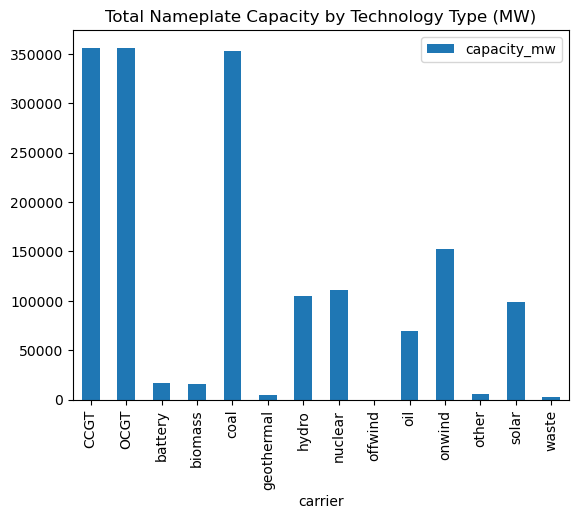

In [13]:
eia_data_operable[['carrier', 'capacity_mw']].groupby('carrier').sum().plot(kind='bar', title='Total Nameplate Capacity by Technology Type (MW)')

## Load ADS Data

In [14]:
def standardize_col_names(columns, prefix="", suffix=""):
    """Standardize column names by removing spaces, converting to lowercase, removing parentheses, and adding prefix and suffix."""
    return [prefix + col.lower().replace(" ", "_").replace("(", "").replace(")", "") + suffix for col in columns]

In [15]:
import os

ADS_PATH = os.path.join('../data/WECC_ADS/downloads/2032/Public Data')
ads_thermal= pd.read_csv(ADS_PATH + '/Thermal_General_Info.csv',skiprows=1, )#encoding='unicode_escape')
ads_thermal = ads_thermal[['GeneratorName', ' Turbine Type', 'MustRun',
       'MinimumDownTime(hr)', 'MinimumUpTime(hr)', 'MaxUpTime(hr)', 'RampUp Rate(MW/minute)',
       'RampDn Rate(MW/minute)', 'Startup Cost Fixed($)', 'StartFuel(MMBTu)', 'Startup Time',
       'VOM Cost']]
ads_thermal.columns = standardize_col_names(ads_thermal.columns)
ads_thermal

generatorname  _turbine_type  mustrun  minimumdowntimehr  \
0            Copper_1             GT    False                  1   
1        Montana_4_G4  GT LMS_LMS100    False                  1   
2        Montana_3_G3  GT LMS_LMS100    False                  1   
3        Montana_2_G2  GT LMS_LMS100    False                  1   
4        Montana_1_G1  GT LMS_LMS100    False                  1   
...               ...            ...      ...                ...   
1503  Fort St Vrain 7       GT F_7FA    False                  1   
1504  Fort St Vrain 8       GT F_7FA    False                  1   
1505  Fort St Vrain 9       GT F_7FA    False                  1   
1506   Spindle Hill 1       GT F_7FA    False                  1   
1507   Spindle Hill 2       GT F_7FA    False                  1   

      minimumuptimehr  maxuptimehr  rampup_ratemw/minute  \
0                   1           -1                  6.40   
1                   1           -1                 80.28   
2                   1           -1                 80.28   
3                   1           -1                 79.38   
4                   1           -1                 79.38   
...               ...          ...                   ...   
1503                1            1                 15.80   
1504                1            1                 15.80   
1505                1            1                 15.80   
1506                1            1                 15.40   
1507                1            1                 15.40   

      rampdn_ratemw/minute  startup_cost_fixed$  startfuelmmbtu  startup_time  \
0                     6.40             3777.897          17.721             1   
1                    80.28             2672.257         453.000             1   
2                    80.28             2672.257         453.000             1   
3                    79.38             2642.299         453.000             1   
4                    79.38             2642.299         453.000             1   
...                    ...                  ...             ...           ...   
1503                 15.80             9326.683          34.760             0   
1504                 15.80             9326.683          34.760             0   
1505                 15.80             9326.683          34.760             0   
1506                 15.40             9090.563          33.880             0   
1507                 15.40             9090.563          33.880             0   

      vom_cost  
0         0.56  
1         0.45  
2         0.45  
3         0.45  
4         0.45  
...        ...  
1503      0.56  
1504      0.56  
1505      0.56  
1506      0.56  
1507      0.56  

[1508 rows x 12 columns]

In [16]:
import numpy as np

ads_ioc= pd.read_csv(ADS_PATH + '/Thermal_IOCurve_Info.csv',skiprows=1, ).rename(columns={'Generator Name':'GeneratorName'})
ads_ioc = ads_ioc[['GeneratorName', 'IOMaxCap(MW)','IOMinCap(MW)', 'MinInput(MMBTu)', 'IncCap2(MW)', 'IncHR2(MMBTu/MWh)',
       'IncCap3(MW)', 'IncHR3(MMBTu/MWh)', 'IncCap4(MW)', 'IncHR4(MMBTu/MWh)',
       'IncCap5(MW)', 'IncHR5(MMBTu/MWh)', 'IncCap6(MW)', 'IncHR6(MMBTu/MWh)',
       'IncCap7(MW)', 'IncHR7(MMBTu/MWh)']]
ads_ioc['IncHR2(MMBTu/MWh)'] = ads_ioc['IncHR2(MMBTu/MWh)'].replace(0, np.nan)
ads_ioc.columns = standardize_col_names(ads_ioc.columns)

ads_ioc['inchr1mmbtu/mwh'] = ads_ioc.mininputmmbtu/ads_ioc.iomincapmw
ads_ioc.rename(
    columns={
        'inchr1mmbtu/mwh':'hr1',
        'inchr2mmbtu/mwh':'hr2',
        'inchr3mmbtu/mwh':'hr3',
        'inchr4mmbtu/mwh':'hr4',
        'inchr5mmbtu/mwh':'hr5',
        'inchr6mmbtu/mwh':'hr6',
        'inchr7mmbtu/mwh':'hr7',
        'iomincapmw':'x_1',
        'mininputmmbtu':'mmbtu_1'
        },
    inplace=True)

for i in range(2, 8):
    ads_ioc[f'x_{i}'] = ads_ioc[f'x_{i-1}'] + ads_ioc[f'inccap{i}mw']
    ads_ioc[f'mmbtu_{i}'] = ads_ioc[f'x_{i}'] * ads_ioc[f'hr{i}']

for i in range(0, ads_ioc.shape[0]):
    for j in range(2, 8):
        if ads_ioc[f'hr{j}'][i] == 0:
            ads_ioc[f'hr{j}'][i] = ads_ioc[f'hr{j-1}'][i]

ads_ioc


/tmp/ipykernel_50148/3519433213.py:33: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ads_ioc[f'hr{j}'][i] = ads_ioc[f'hr{j-1}'][i]
/tmp/ipykernel_50148/3519433213.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

generatorname  iomaxcapmw   x_1   mmbtu_1  inccap2mw    hr2  \
0            Copper_1        68.0  10.0  348.1817     19.333  9.449   
1        Montana_4_G4        97.0  50.0  502.4456     15.667  6.812   
2        Montana_3_G3        97.0  50.0  516.5762     15.667  7.194   
3        Montana_2_G2        97.0  50.0  506.7479     15.667  6.747   
4        Montana_1_G1        93.2  50.0  501.2907     14.400  6.879   
...               ...         ...   ...       ...        ...    ...   
1501  Fort St Vrain 7       160.0  70.0  932.6521     30.000  6.864   
1502  Fort St Vrain 8       160.0  70.0  932.6521     30.000  6.864   
1503  Fort St Vrain 9       160.0  70.0  932.6521     30.000  6.864   
1504   Spindle Hill 1       160.0  81.0  983.4004     26.333  7.002   
1505   Spindle Hill 2       160.0  80.0  989.1603     26.667  6.721   

      inccap3mw     hr3  inccap4mw     hr4  ...      x_3      mmbtu_3    x_4  \
0        38.667  11.047      0.000  11.047  ...   68.000   751.196000   68.0   
1        31.333   7.315      0.000   7.315  ...   97.000   709.555000   97.0   
2        31.333   7.365      0.000   7.365  ...   97.000   714.405000   97.0   
3        31.333   7.028      0.000   7.028  ...   97.000   681.716000   97.0   
4        28.800   7.218      0.000   7.218  ...   93.200   672.717600   93.2   
...         ...     ...        ...     ...  ...      ...          ...    ...   
1501     30.000   7.691     30.000   8.519  ...  130.000   999.830000  160.0   
1502     30.000   7.691     30.000   8.519  ...  130.000   999.830000  160.0   
1503     30.000   7.691     30.000   8.519  ...  130.000   999.830000  160.0   
1504     26.334   7.394     26.333   7.785  ...  133.667   988.333798  160.0   
1505     26.666   7.567     26.667   8.414  ...  133.333  1008.930811  160.0   

      mmbtu_4    x_5  mmbtu_5    x_6  mmbtu_6    x_7  mmbtu_7  
0        0.00   68.0      0.0   68.0      0.0   68.0      0.0  
1        0.00   97.0      0.0   97.0      0.0   97.0      0.0  
2        0.00   97.0      0.0   97.0      0.0   97.0      0.0  
3        0.00   97.0      0.0   97.0      0.0   97.0      0.0  
4        0.00   93.2      0.0   93.2      0.0   93.2      0.0  
...       ...    ...      ...    ...      ...    ...      ...  
1501  1363.04  160.0      0.0  160.0      0.0  160.0      0.0  
1502  1363.04  160.0      0.0  160.0      0.0  160.0      0.0  
1503  1363.04  160.0      0.0  160.0      0.0  160.0      0.0  
1504  1245.60  160.0      0.0  160.0      0.0  160.0      0.0  
1505  1346.24  160.0      0.0  160.0      0.0  160.0      0.0  

[1506 rows x 29 columns]

In [17]:
import numpy as np
def detail_linspace(x_values, y_values, num_points):
    # Arrays to hold the detailed linspace results
    x_detailed = np.array([])
    y_detailed = np.array([])

    for i in range(len(x_values) - 1):
        if x_values[i] == x_values[i+1]:
            continue
        # Generate linspace for x values
        x_segment = np.linspace(x_values[i], x_values[i+1], num_points, endpoint=False)

        # Calculate the slope of the segment
        slope = (y_values[i+1] - y_values[i]) / (x_values[i+1] - x_values[i])

        # Generate y values based on the slope and start point
        y_segment = slope * (x_segment - x_values[i]) + y_values[i]

        # Append the segment to the detailed arrays
        x_detailed = np.concatenate((x_detailed, x_segment))
        y_detailed = np.concatenate((y_detailed, y_segment))

    return x_detailed, y_detailed

In [18]:
import numpy as np
from scipy.optimize import minimize

# Define quadratic error function
def quadratic_error_function(params, x, y_true):
    a, b, c = params
    y_pred = a*x**2 + b*x + c
    return np.sum((y_true - y_pred)**2)

def linear_error_function(params, x, y_true):
    a, b = params
    y_pred = a*x + b
    return np.sum((y_true - y_pred)**2)

ads_ioc['linear_a'] = 0
ads_ioc['linear_b'] = 0
ads_ioc['quadratic_a'] = 0
ads_ioc['quadratic_b'] = 0
ads_ioc['quadratic_c'] = 0
ads_ioc['avg_hr'] = 0

for generator_index in range(ads_ioc.shape[0]):
    # generator_index = 0
    x_set_points = ads_ioc[['x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7']].values[generator_index,:]
    y_vals_hr = ads_ioc[['hr1', 'hr2', 'hr3', 'hr4', 'hr5', 'hr6', 'hr7']].values[generator_index,:]
    y_vals = ads_ioc[['mmbtu_1', 'mmbtu_2', 'mmbtu_3', 'mmbtu_4', 'mmbtu_5', 'mmbtu_6', 'mmbtu_7']].values[generator_index,:]

    x_linspace, y_linspace = detail_linspace(x_set_points, y_vals, 10)

    initial_guess = [0.1, 0.1, 0.1]
    result_quad = minimize(quadratic_error_function, initial_guess, args=(x_linspace, y_linspace))

    initial_guess_lin = [0.1, 0.1]
    result_linear = minimize(linear_error_function, initial_guess_lin, args=(x_linspace, y_linspace))


    a_opt, b_opt, c_opt = result_quad.x
    # print(f"Quadratic parameters: a = {a_opt}, b = {b_opt}, c = {c_opt}")

    a_opt_lin, b_opt_lin = result_linear.x
    # print(f"Linear parameters: a = {a_opt_lin}, b = {b_opt_lin}")

    avg_hr = np.mean((a_opt_lin * x_linspace  + b_opt_lin) / x_linspace)
    # print(f"Average heat rate: {avg_hr}")

    ads_ioc.loc[generator_index, 'linear_a'] = a_opt_lin
    ads_ioc.loc[generator_index, 'linear_b'] = b_opt_lin
    ads_ioc.loc[generator_index, 'quadratic_a'] = a_opt
    ads_ioc.loc[generator_index, 'quadratic_b'] = b_opt
    ads_ioc.loc[generator_index, 'quadratic_c'] = c_opt
    ads_ioc.loc[generator_index, 'avg_hr'] = avg_hr

/tmp/ipykernel_50148/3886041.py:46: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '7.021107341223485' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ads_ioc.loc[generator_index, 'linear_a'] = a_opt_lin
/tmp/ipykernel_50148/3886041.py:47: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '173.64677055256612' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ads_ioc.loc[generator_index, 'linear_b'] = b_opt_lin
/tmp/ipykernel_50148/3886041.py:48: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2384999724508151' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ads_ioc.loc[generator_index, 'quadratic_a'] = a_opt
/tmp/ipykernel_50148/

In [19]:
# Check for inf and nan values in avg_hr, and replace with nan.
# This is done so we can identify plants without data, then replace with averages later
print("# of np.inf in avg_hr: ", np.sum(abs(ads_ioc['avg_hr']) == np.inf))
print("# of np.nan in avg_hr: ", np.sum(abs(ads_ioc['avg_hr']) == np.nan))
ads_ioc['avg_hr'] = ads_ioc['avg_hr'].replace([np.inf, -np.inf], np.nan)

# of np.inf in avg_hr:  11
# of np.nan in avg_hr:  0


In [20]:
# Plotting IOC Results
generator_index = 102 #1050
x_set_points = ads_ioc[['x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7']].values[generator_index,:]
y_vals_hr = ads_ioc[['hr1', 'hr2', 'hr3', 'hr4', 'hr5', 'hr6', 'hr7']].values[generator_index,:]
y_vals = ads_ioc[['mmbtu_1', 'mmbtu_2', 'mmbtu_3', 'mmbtu_4', 'mmbtu_5', 'mmbtu_6', 'mmbtu_7']].values[generator_index,:]
x_linspace, y_linspace = detail_linspace(x_set_points, y_vals, 10)

a_opt, b_opt, c_opt = ads_ioc.loc[generator_index, ['quadratic_a', 'quadratic_b', 'quadratic_c']]
a_opt_lin, b_opt_lin = ads_ioc.loc[generator_index, ['linear_a', 'linear_b']]

print('set points: ', x_set_points)
print('heat values: ',y_vals)
print('y_vals_hr: ', y_vals_hr)

ads_ioc.iloc[generator_index, :]

set points:  [ 941. 1200. 1200. 1200. 1200. 1200. 1200.]
heat values:  [12867.88 13200.       0.       0.       0.       0.       0.  ]
y_vals_hr:  [13.6746865 11.        11.        11.        11.        11.
 11.       ]


generatorname    DiabloCanyon1
iomaxcapmw              1200.0
x_1                      941.0
mmbtu_1               12867.88
inccap2mw                259.0
hr2                       11.0
inccap3mw                  0.0
hr3                       11.0
inccap4mw                  0.0
hr4                       11.0
inccap5mw                  0.0
hr5                       11.0
inccap6mw                  0.0
hr6                       11.0
inccap7mw                    0
hr7                       11.0
hr1                  13.674687
x_2                     1200.0
mmbtu_2                13200.0
x_3                     1200.0
mmbtu_3                    0.0
x_4                     1200.0
mmbtu_4                    0.0
x_5                     1200.0
mmbtu_5                    0.0
x_6                     1200.0
mmbtu_6                    0.0
x_7                     1200.0
mmbtu_7                    0.0
linear_a              1.282315
linear_b          11661.221676
quadratic_a          -0.000302
quadrati

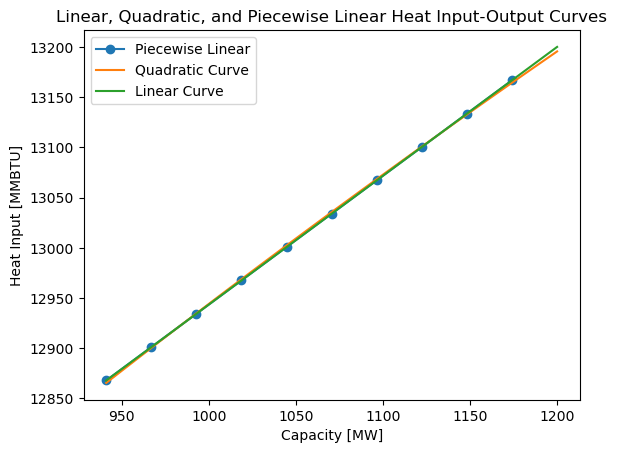

In [21]:
# Plotting IOC Results
import matplotlib.pyplot as plt

# Plot piecewise linear x and y values
plt.plot(x_linspace, y_linspace, 'o-', label='Piecewise Linear')

# Plot quadratic curve
x = np.linspace(min(x_set_points), max(x_set_points), 100)
y = a_opt * x**2 + b_opt * x + c_opt
plt.plot(x, y, label='Quadratic Curve')


# Plot linear term
y = a_opt_lin * x + b_opt_lin
plt.plot(x, y, label='Linear Curve')


# Set labels and title
plt.xlabel('Capacity [MW]')
plt.ylabel('Heat Input [MMBTU]')
plt.title('Piecewise Linear and Quadratic Curve')

plt.legend()
plt.title('Linear, Quadratic, and Piecewise Linear Heat Input-Output Curves')
plt.show()


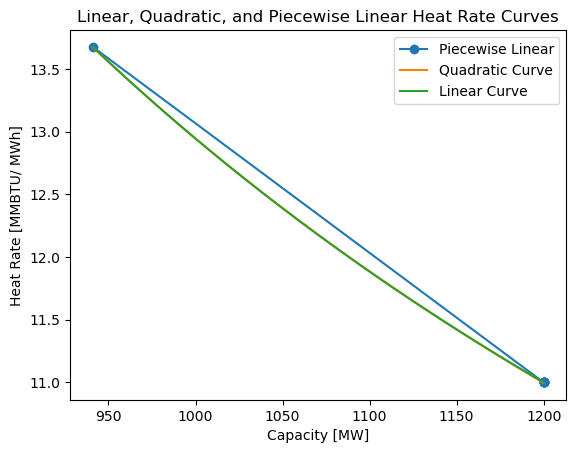

In [22]:
# Plot piecewise linear x and y values
plt.plot(x_set_points, y_vals_hr, 'o-', label='Piecewise Linear')

# Plot quadratic curve
x = np.linspace(min(x_set_points), max(x_set_points), 100)
y = (a_opt * x**2 + b_opt * x + c_opt)/ x
plt.plot(x, y, label='Quadratic Curve')

# Plot linear term
y = (a_opt_lin * x + b_opt_lin) / x
plt.plot(x, y, label='Linear Curve')

# Set labels and title
plt.xlabel('Capacity [MW]')
plt.ylabel('Heat Rate [MMBTU/ MWh]')
plt.title('Piecewise Linear and Quadratic Curve')

plt.legend()
plt.title('Linear, Quadratic, and Piecewise Linear Heat Rate Curves')
plt.show()


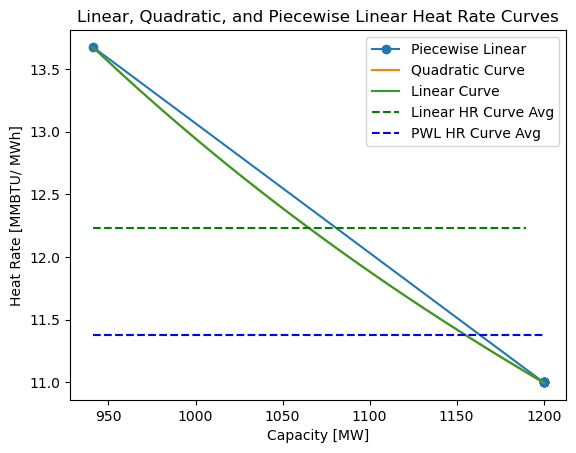

In [23]:
# Plot piecewise linear x and y values
plt.plot(x_set_points, y_vals_hr, 'o-', label='Piecewise Linear')

# Plot quadratic curve
x = np.linspace(min(x_set_points), max(x_set_points), 100)
y = (a_opt * x**2 + b_opt * x + c_opt)/ x
plt.plot(x, y, label='Quadratic Curve')

# Plot linear term
y = (a_opt_lin * x + b_opt_lin) / x
plt.plot(x, y, label='Linear Curve')

y = np.mean((a_opt_lin * x + b_opt_lin) / x) * np.ones_like(x)
plt.plot(x[::5], y[::5], c='green', linestyle='--', label='Linear HR Curve Avg')

y = np.mean(y_vals_hr) * np.ones_like(x_set_points)
plt.plot(x_set_points[::5], y[::5], c='blue', linestyle='--', label='PWL HR Curve Avg')


# Set labels and title
plt.xlabel('Capacity [MW]')
plt.ylabel('Heat Rate [MMBTU/ MWh]')
plt.title('Piecewise Linear and Quadratic Curve')

plt.legend()
plt.title('Linear, Quadratic, and Piecewise Linear Heat Rate Curves')
plt.show()

In [24]:
# Merge ADS plant data with thermal IOC data
ads_thermal_ioc = pd.merge(ads_thermal, ads_ioc, on='generatorname', how='left')
ads_thermal_ioc.dropna(subset=['avg_hr'])


generatorname  _turbine_type  mustrun  minimumdowntimehr  \
0            Copper_1             GT    False                  1   
1        Montana_4_G4  GT LMS_LMS100    False                  1   
2        Montana_3_G3  GT LMS_LMS100    False                  1   
3        Montana_2_G2  GT LMS_LMS100    False                  1   
4        Montana_1_G1  GT LMS_LMS100    False                  1   
...               ...            ...      ...                ...   
1503  Fort St Vrain 7       GT F_7FA    False                  1   
1504  Fort St Vrain 8       GT F_7FA    False                  1   
1505  Fort St Vrain 9       GT F_7FA    False                  1   
1506   Spindle Hill 1       GT F_7FA    False                  1   
1507   Spindle Hill 2       GT F_7FA    False                  1   

      minimumuptimehr  maxuptimehr  rampup_ratemw/minute  \
0                   1           -1                  6.40   
1                   1           -1                 80.28   
2                   1           -1                 80.28   
3                   1           -1                 79.38   
4                   1           -1                 79.38   
...               ...          ...                   ...   
1503                1            1                 15.80   
1504                1            1                 15.80   
1505                1            1                 15.80   
1506                1            1                 15.40   
1507                1            1                 15.40   

      rampdn_ratemw/minute  startup_cost_fixed$  startfuelmmbtu  ...    x_6  \
0                     6.40             3777.897          17.721  ...   68.0   
1                    80.28             2672.257         453.000  ...   97.0   
2                    80.28             2672.257         453.000  ...   97.0   
3                    79.38             2642.299         453.000  ...   97.0   
4                    79.38             2642.299         453.000  ...   93.2   
...                    ...                  ...             ...  ...    ...   
1503                 15.80             9326.683          34.760  ...  160.0   
1504                 15.80             9326.683          34.760  ...  160.0   
1505                 15.80             9326.683          34.760  ...  160.0   
1506                 15.40             9090.563          33.880  ...  160.0   
1507                 15.40             9090.563          33.880  ...  160.0   

      mmbtu_6    x_7  mmbtu_7  linear_a    linear_b  quadratic_a  quadratic_b  \
0         0.0   68.0      0.0  7.021107  173.646771     0.238500   -10.280470   
1         0.0   97.0      0.0  4.460706  216.334021     0.219595   -26.848744   
2         0.0   97.0      0.0  4.257123  247.780391     0.194749   -23.509882   
3         0.0   97.0      0.0  3.775915  255.964749     0.215805   -26.993272   
4         0.0   93.2      0.0  4.022975  241.502691     0.241639   -29.597634   
...       ...    ...      ...       ...         ...          ...          ...   
1503      0.0  160.0      0.0  5.590548  302.991677     0.174327   -33.981632   
1504      0.0  160.0      0.0  5.590548  302.991677     0.174327   -33.981632   
1505      0.0  160.0      0.0  5.590548  302.991677     0.174327   -33.981632   
1506      0.0  160.0      0.0  4.167813  450.356034     0.182272   -39.279754   
1507      0.0  160.0      0.0  5.398198  317.975829     0.220824   -47.010625   

      quadratic_c     avg_hr  
0      419.167036  14.127096  
1     1291.077675   7.742335  
2     1200.924365   8.015771  
3     1312.162860   7.658713  
4     1372.594417   7.751620  
...           ...        ...  
1503  2431.172959   8.414619  
1504  2431.172959   8.414619  
1505  2431.172959   8.414619  
1506  2944.777137   8.094555  
1507  3309.924200   8.186646  

[1362 rows x 46 columns]

In [25]:
#loading ads to match ads_name with generator key in order to link with ads thermal file
import re


ads= pd.read_csv(ADS_PATH + '/GeneratorList.csv',skiprows=2, encoding='unicode_escape')
# ads = ads[ads['State'].isin(['NM', 'AZ', 'CA', 'WA', 'OR', 'ID', 'WY', 'MT', 'UT', 'SD', 'CO', 'NV', 'NE', '0', 'TX'])]
ads['Long Name'] = ads['Long Name'].astype(str)
ads['Name'] = ads['Name'].str.replace(" ", "")
ads['Name'] = ads['Name'].apply(lambda x: re.sub(r'[^a-zA-Z0-9]', '', x).lower())
ads['Long Name'] = ads['Long Name'].str.replace(" ", "")
ads['Long Name'] = ads['Long Name'].apply(lambda x: re.sub(r'[^a-zA-Z0-9]', '', x).lower())
ads['SubType'] = ads['SubType'].apply(lambda x: re.sub(r'[^a-zA-Z0-9]', '', x).lower())
ads.rename({'Name': 'ads_name', 'Long Name': 'ads_long_name',
             'SubType': 'subtype','Commission Date':'commission_date',
             'Retirement Date':'retirement_date','Area Name':'balancing_area'},
               axis=1, inplace=True)
ads.rename(str.lower, axis='columns', inplace=True)
ads['long id'] = ads['long id'].astype(str)
ads = ads.loc[:, ~ads.columns.isin(['save to binary', 'county', 'city','zipcode', 'internalid'])]
ads_name_key_dict = dict(zip(ads['ads_name'], ads['generatorkey']))
ads.columns

Index(['generatorkey', 'ads_name', 'bus id', 'bus name', 'bus kv', 'unit id',
       'generator typeid', 'subtype', 'long id', 'ads_long_name',
       'servicestatus', 'commission_date', 'retirement_date', 'devstatus',
       'balancing_area', 'region name', 'mincap(mw)', 'maxcap(mw)',
       'initialdispatch(mw)', 'state', 'fueltype', 'technology', 'btm',
       'economicpmin', 'economicpmax'],
      dtype='object')

In [26]:
ads_thermal_ioc['generator_name_alt'] = ads_thermal_ioc['generatorname'].str.replace(" ", "").str.lower().str.replace('_',"").str.replace('-','')
ads_thermal_ioc['generator_key'] = ads_thermal_ioc['generator_name_alt'].map(ads_name_key_dict)

# Identify Generators not in ads generator list that are in the IOC curve. This could potentially be matched with manual work.
ads_thermal_ioc[ads_thermal_ioc.generator_key.isna()]

generatorname _turbine_type  \
504                                  SonomaCentralLF1+2            ST   
506                                     zzebraNLG-.4G-1    PF Dynamic   
507                                     zzebraNLG-.4G-2    PF Dynamic   
908                                  GP Wauna Mill (CG)         OT ST   
930                                   CHEV.USA_35052_RT           NaN   
...                                                 ...           ...   
1461  Roseburg Forest Products Company - Dillard5ST11.5        BIO-ST   
1462  Roseburg Forest Products Company - Dillard6ST11.5        BIO-ST   
1463                            Crystal Mountain1IC2.75            IC   
1469                                  Bonnybrook (BON1)           NaN   
1478                                West Pembina (PMB1)            CT   

      mustrun  minimumdowntimehr  minimumuptimehr  maxuptimehr  \
504      True                  8                5           -1   
506     False                  1                1           -1   
507     False                  1                1           -1   
908     False                  7               48           -1   
930     False                  4                2           -1   
...       ...                ...              ...          ...   
1461     True                  8                6           -1   
1462     True                  8                6           -1   
1463     True                  8                6           -1   
1469     True                  4                2            1   
1478    False                  1                1           -1   

      rampup_ratemw/minute  rampdn_ratemw/minute  startup_cost_fixed$  \
504                1.80000               1.80000             45.06636   
506                0.01000               0.01000              3.25000   
507                0.01000               0.01000              3.25000   
908               83.33334              83.33334              0.00000   
930                1.16000               1.16000            796.97750   
...                    ...                   ...                  ...   
1461               1.80000               1.80000             84.49943   
1462               1.80000               1.80000             84.49943   
1463               1.80000               1.80000             84.49943   
1469               1.50000               1.50000           1030.57400   
1478              30.60000              30.60000           1177.00000   

      startfuelmmbtu  ...    x_7  mmbtu_7   linear_a      linear_b  \
504             0.80  ...   6.00      0.0  13.633889  6.670184e-04   
506             1.25  ...   0.63      0.0  97.984000 -1.793072e-07   
507             1.25  ...   0.63      0.0  97.984000 -1.793072e-07   
908             0.00  ...  23.70      0.0  11.000000  2.487617e-07   
930             0.00  ...  11.60      0.0  11.000000  1.086395e-07   
...              ...  ...    ...      ...        ...           ...   
1461            1.50  ...  11.50      0.0   8.489643  3.828761e+01   
1462            1.50  ...  11.50      0.0   8.489643  3.828761e+01   
1463            1.50  ...   2.75      0.0   0.100000  1.000000e-01   
1469            1.50  ...  15.00      0.0 -21.700001  4.170000e+02   
1478           14.11  ...  13.00      0.0 -26.605429  4.260026e+02   

       quadratic_a  quadratic_b   quadratic_c     avg_hr  \
504  -2.045406e-06    13.633905  6.361632e-04  13.634067   
506   3.923056e-06    97.983997  3.622496e-07        NaN   
507   3.923056e-06    97.983997  3.622496e-07        NaN   
908  -2.013926e-07    11.000004 -1.332567e-05        NaN   
930  -1.855510e-07    11.000002 -2.884996e-06        NaN   
...            ...          ...           ...        ...   
1461 -3.865175e-07     8.489648  3.828759e+01  13.889922   
1462 -3.865175e-07     8.489648  3.828759e+01  13.889922   
1463  1.000000e-01     0.100000  1.000000e-01        NaN   
1469 -4.697135e-05   -21.698850  4.169931e+02  12.8204

In [27]:
# Merge ads thermal_IOC data with ads generator data
# Only keeping thermal plants for their heat rate and ramping data
ads_complete = ads_thermal_ioc.merge(ads, left_on='generator_key', right_on='generatorkey', how='left')
ads_complete.columns = standardize_col_names(ads_complete.columns, prefix='ads_')
ads_complete = ads_complete.loc[~ads_complete.ads_state.isin(['MX'])]
ads_complete

ads_generatorname ads__turbine_type  ads_mustrun  ads_minimumdowntimehr  \
0             Copper_1                GT        False                      1   
1         Montana_4_G4     GT LMS_LMS100        False                      1   
2         Montana_3_G3     GT LMS_LMS100        False                      1   
3         Montana_2_G2     GT LMS_LMS100        False                      1   
4         Montana_1_G1     GT LMS_LMS100        False                      1   
...                ...               ...          ...                    ...   
1503   Fort St Vrain 7          GT F_7FA        False                      1   
1504   Fort St Vrain 8          GT F_7FA        False                      1   
1505   Fort St Vrain 9          GT F_7FA        False                      1   
1506    Spindle Hill 1          GT F_7FA        False                      1   
1507    Spindle Hill 2          GT F_7FA        False                      1   

      ads_minimumuptimehr  ads_maxuptimehr  ads_rampup_ratemw/minute  \
0                       1               -1                      6.40   
1                       1               -1                     80.28   
2                       1               -1                     80.28   
3                       1               -1                     79.38   
4                       1               -1                     79.38   
...                   ...              ...                       ...   
1503                    1                1                     15.80   
1504                    1                1                     15.80   
1505                    1                1                     15.80   
1506                    1                1                     15.40   
1507                    1                1                     15.40   

      ads_rampdn_ratemw/minute  ads_startup_cost_fixed$  ads_startfuelmmbtu  \
0                         6.40                 3777.897              17.721   
1                        80.28                 2672.257             453.000   
2                        80.28                 2672.257             453.000   
3                        79.38                 2642.299             453.000   
4                        79.38                 2642.299             453.000   
...                        ...                      ...                 ...   
1503                     15.80                 9326.683              34.760   
1504                     15.80                 9326.683              34.760   
1505                     15.80                 9326.683              34.760   
1506                     15.40                 9090.563              33.880   
1507                     15.40                 9090.563              33.880   

      ...  ads_region_name  ads_mincapmw  ads_maxcapmw  ads_initialdispatchmw  \
0     ...           SW_EPE          10.0          68.0                   45.0   
1     ...           SW_EPE          50.0          97.0                   68.0   
2     ...           SW_EPE          50.0          97.0                   68.0   
3     ...           SW_EPE          50.0          97.0                   68.0   
4     ...           SW_EPE          50.0          93.2                   68.0   
...   ...              ...           ...           ...                    ...   
1503  ...          RM_PSCO          70.0         160.0                    0.0   
1504  ...          RM_PSCO          70.0         160.0                    0.0   
1505  ...          RM_PSCO          70.0         160.0                    0.0   
1506  ...          RM_PSCO          81.0         160.0                    0.0   
1507  ...          RM_PSCO          80.0         160.0                    0.0   

      ads_state  ads_fueltype  ads_technology  ads_btm  ads_economicpmin  \
0            TX            NG      Industrial  #FALSE#                10   
1            TX            NG            Areo  #FALSE#                50   
2            TX            NG

In [28]:
ads_complete.pivot_table(index=['ads_fueltype'], values='ads_avg_hr', aggfunc='mean').sort_values('ads_avg_hr', ascending=False)

ads_avg_hr
ads_fueltype                  
Bio                  21.660585
Water                15.097340
Biomass Waste        13.933593
Landfill Gas         13.661451
Oil                  13.239536
Uranium              12.364001
Natural Gas          12.151512
Coal                 10.646793
Nuclear              10.603626
Subbituminous Coal   10.350997
NG                    9.913503
Petroleum Coke        9.750158
NatGas                9.475063
WH                    9.359829
Combined Cycle        6.735413
Geo                   6.679001

### Merging EIA and ADS Data

In [29]:
#load mapping file to match the ads thermal to the eia_plants_locs file
eia_ads_mapper = pd.read_csv('../repo_data/eia_ads_generator_mapping_updated.csv')
eia_ads_mapper = eia_ads_mapper.loc[:,[
                                    'generatorkey', 'ads_name', 'plant_id_ads',
                                    'plant_id_eia', 'generator_id_ads']]
eia_ads_mapper.columns = standardize_col_names(eia_ads_mapper.columns, prefix='mapper_')
eia_ads_mapper.dropna(subset=['mapper_plant_id_eia'], inplace=True)
eia_ads_mapper.mapper_plant_id_eia = eia_ads_mapper.mapper_plant_id_eia.astype(int)
eia_ads_mapper.mapper_ads_name = eia_ads_mapper.mapper_ads_name.astype(str)
eia_ads_mapper.mapper_generatorkey = eia_ads_mapper.mapper_generatorkey.astype(int)
eia_ads_mapper

mapper_generatorkey   mapper_ads_name mapper_plant_id_ads  \
0                   20644    clearwaterwind               65577   
1                   17647       hotpotsolar                   _   
2                   16797   jicarillasolar2              Future   
3                   20636         niyolwind               65059   
4                   17446  kingsriversyphon                   _   
...                   ...               ...                 ...   
2714                14153      montaguewind               58099   
2715                17099         newmancc7                3456   
2716                17102        newman6gt5                3456   
2804                16024        newmancc5a                3456   
2805                16025        newmancc5b                3456   

      mapper_plant_id_eia mapper_generator_id_ads  
0                   65577                     CW1  
1                   65419                     NaN  
2                   65103                   Tier3  
3                   65059                   WNIYO  
4                   65033                     NaN  
...                   ...                     ...  
2714                58099                       1  
2715                 3456                      AG  
2716                 3456                     NaN  
2804                 3456                      AG  
2805                 3456                      AG  

[2715 rows x 5 columns]

In [30]:
ads_complete.dropna(subset=['ads_generator_key'], inplace=True)
ads_complete.ads_generator_key = ads_complete.ads_generator_key.astype(int)
eia_ads_mapper.mapper_generatorkey = eia_ads_mapper.mapper_generatorkey.astype(int)

In [31]:
eia_ads_mapping = pd.merge(ads_complete, eia_ads_mapper, left_on= 'ads_generator_key', right_on= 'mapper_generatorkey', how='inner')
eia_ads_mapping

ads_generatorname ads__turbine_type  ads_mustrun  \
0                         Montana_4_G4     GT LMS_LMS100        False   
1                         Montana_3_G3     GT LMS_LMS100        False   
2                         Montana_2_G2     GT LMS_LMS100        False   
3                         Montana_1_G1     GT LMS_LMS100        False   
4                          Chula_Vista       GT Aero_FT4        False   
...                                ...               ...          ...   
1065                   Scattergood CC3        CC F_7F.05        False   
1066  InternationalPaperEnergyCenter 2             OT ST         True   
1067             Raft River Geothermal               GEO         True   
1068                    Spindle Hill 1          GT F_7FA        False   
1069                    Spindle Hill 2          GT F_7FA        False   

      ads_minimumdowntimehr  ads_minimumuptimehr  ads_maxuptimehr  \
0                         1                    1               -1   
1                         1                    1               -1   
2                         1                    1               -1   
3                         1                    1               -1   
4                         1                    1               -1   
...                     ...                  ...              ...   
1065                      1                    1               -1   
1066                      8                    8                1   
1067                      6                   16                1   
1068                      1                    1                1   
1069                      1                    1                1   

      ads_rampup_ratemw/minute  ads_rampdn_ratemw/minute  \
0                        80.28                     80.28   
1                        80.28                     80.28   
2                        79.38                     79.38   
3                        79.38                     79.38   
4                        31.95                     31.95   
...                        ...                       ...   
1065                     30.00                     30.00   
1066                      1.80                      1.80   
1067                      6.67                      6.67   
1068                     15.40                     15.40   
1069                     15.40                     15.40   

      ads_startup_cost_fixed$  ads_startfuelmmbtu  ...  ads_fueltype  \
0                  2672.25700             453.000  ...            NG   
1                  2672.25700             453.000  ...            NG   
2                  2642.29900             453.000  ...            NG   
3                  2642.29900             453.000  ...            NG   
4                  1063.51000             160.815  ...            NG   
...                       ...                 ...  ...           ...   
1065              17708.89000              44.000  ...            NG   
1066                 70.41619               1.250  ...           Bio   
1067                  0.00000               0.000  ...           Geo   
1068               9090.56300              33.880  ...            NG   
1069               9090.56300              33.880  ...            NG   

      ads_technology  ads_btm  ads_economicpmin  ads_economicpmax  \
0               Areo  #FALSE#                50                97   
1               Areo  #FALSE#                50                97   
2               Areo  #FALSE#                50                97   
3               Areo  #FALSE#                50              93.2   
4               Areo  #FALSE#             4.375                35   
...              ...      ...               ...               ...   
1065      Industrial  #FALSE#           111.685               311   
1066             NaN  #FALSE#                 8                40   
1067          Binary  #FALSE#               5.5                12   
1068      Industrial  #FALSE#          

In [32]:
#ID MISSING ADS GENERATORS
# find missing ones not mapped
ads_missing = ads_complete[~ads_complete.ads_generator_key.isin(eia_ads_mapping.ads_generator_key)]
ads_missing

ads_generatorname ads__turbine_type  ads_mustrun  \
0               Copper_1                GT        False   
111            Fellow_QF                GT        False   
233          NW_Energy_1             OT ST         True   
234            McMahon_1                GT        False   
235            McMahon_2                GT        False   
...                  ...               ...          ...   
1501       Fresno Peaker                GT        False   
1502  Ben French ICE 1-5                IC        False   
1503     Fort St Vrain 7          GT F_7FA        False   
1504     Fort St Vrain 8          GT F_7FA        False   
1505     Fort St Vrain 9          GT F_7FA        False   

      ads_minimumdowntimehr  ads_minimumuptimehr  ads_maxuptimehr  \
0                         1                    1               -1   
111                       1                    1               -1   
233                       8                    8               -1   
234                       1                    1               -1   
235                       1                    1               -1   
...                     ...                  ...              ...   
1501                      1                    1                1   
1502                      1                    1               -1   
1503                      1                    1                1   
1504                      1                    1                1   
1505                      1                    1                1   

      ads_rampup_ratemw/minute  ads_rampdn_ratemw/minute  \
0                        6.400                     6.400   
111                     15.525                    15.525   
233                      1.800                     1.800   
234                      5.500                     5.500   
235                      5.500                     5.500   
...                        ...                       ...   
1501                    15.840                    15.840   
1502                     9.500                     9.500   
1503                    15.800                    15.800   
1504                    15.800                    15.800   
1505                    15.800                    15.800   

      ads_startup_cost_fixed$  ads_startfuelmmbtu  ...  ads_region_name  \
0                   3777.8970              17.721  ...           SW_EPE   
111                  397.4200             110.470  ...          CA_CISO   
233                  381.3178               6.769  ...          BC_BCHA   
234                 3246.6300              12.100  ...          BC_BCHA   
235                 3246.6300              12.100  ...          BC_BCHA   
...                       ...                 ...  ...              ...   
1501                 365.3000              61.670  ...          CA_CISO   
1502                 100.0000               1.000  ...          RM_WACM   
1503                9326.6830              34.760  ...          RM_PSCO   
1504                9326.6830              34.760  ...          RM_PSCO   
1505                9326.6830              34.760  ...          RM_PSCO   

      ads_mincapmw  ads_maxcapmw  ads_initialdispatchmw  ads_state  \
0           10.000        68.000                 45.000         TX   
111          3.200         6.200                  0.990         CA   
233         30.461        67.691                 51.700         BC   
234         27.500        55.000                 42.639         BC   
235         27.500        55.000                 36.361         BC   
...            ...           ...                    ...        ...   
1501        13.900        21.900                  0.000         CA   
1502         2.500        10.000                  0.000         CO   
1503        70.000       160.000                  0.000         CO   
1504        70.000       160.000                  0.000         CO   
1505        70.000       160.000                  0.000         CO   

      

In [33]:
# Merge EIA and ADS Data

eia_ads_merged = pd.merge(
        left = eia_data_operable,
        right = eia_ads_mapping,
        left_on=['plant_id_eia','generator_id'],
        right_on=['mapper_plant_id_eia', 'mapper_generator_id_ads'],
        how='left')
eia_ads_merged.drop(columns=eia_ads_mapper.columns, inplace=True)
eia_ads_merged.drop(columns=['ads_x_1', 'ads_mmbtu_1', 'ads_inccap2mw', 'ads_hr2', 'ads_inccap3mw', 'ads_hr3', 'ads_inccap4mw', 'ads_hr4', 'ads_inccap5mw', 'ads_hr5', 'ads_inccap6mw', 'ads_hr6', 'ads_inccap7mw', 'ads_hr7', 'ads_hr1', 'ads_x_2', 'ads_mmbtu_2', 'ads_x_3', 'ads_mmbtu_3', 'ads_x_4', 'ads_mmbtu_4', 'ads_x_5', 'ads_mmbtu_5', 'ads_x_6', 'ads_mmbtu_6', 'ads_x_7', 'ads_mmbtu_7','ads_generator_name_alt', 'ads_generator_key', 'ads_generatorkey', 'ads_ads_name', 'ads_bus_id', 'ads_bus_name', 'ads_bus_kv', 'ads_unit_id', 'ads_generator_typeid', 'ads_subtype', 'ads_long_id', 'ads_ads_long_name',], inplace=True)
eia_ads_merged= eia_ads_merged.drop_duplicates(subset=['plant_id_eia', 'generator_id'], keep='first')
eia_ads_merged[eia_ads_merged['ads_btm'].notnull()]

plant_id_eia generator_id          plant_name_eia  capacity_mw  \
12              550            1            Kettle Falls    50.700001   
20              607            2                Fredonia   129.100006   
138           50886         GEN1                 Spokane    26.000000   
143           50931         GEN1   Yellowstone Energy LP    68.000000   
152           52015         GEN1            Dixie Valley    64.699997   
...             ...          ...                     ...          ...   
32943         55540         GEN1             Chula Vista    37.200001   
32944         55541         CTG1  Indigo Energy Facility    49.900002   
33161          8028            3                  Arvada     7.500000   
33179         10387            2   Sycamore Energy 1 LLC     0.900000   
33415         55538         GEN1               Escondido    44.000000   

       summer_capacity_mw  winter_capacity_mw  minimum_load_mw  \
12              50.000000           50.700001        12.000000   
20              93.000000          114.000000        40.000000   
138             22.700001           22.700001         4.000000   
143             52.000000           55.000000        22.000000   
152             56.000000           57.000000         5.000000   
...                   ...                 ...              ...   
32943           37.200001           37.200001        30.000000   
32944           46.700001           46.700001        37.400002   
33161            5.000000            6.000000         0.500000   
33179            0.700000            0.700000              NaN   
33415           33.599998           34.599998              NaN   

      energy_source_code_1                technology_description  \
12                     WDS               Wood/Wood Waste Biomass   
20                      NG  Natural Gas Fired Combustion Turbine   
138                    MSW                 Municipal Solid Waste   
143                     PC                        Petroleum Coke   
152                    GEO                            Geothermal   
...                    ...                                   ...   
32943                   NG  Natural Gas Fired Combustion Turbine   
32944                   NG  Natural Gas Fired Combustion Turbine   
33161                   NG  Natural Gas Fired Combustion Turbine   
33179                  LFG                          Landfill Gas   
33415                   NG  Natural Gas Fired Combustion Turbine   

      operational_status  ... ads_region_name ads_mincapmw  ads_maxcapmw  \
12              existing  ...          NW_AVA       46.700        50.700   
20              existing  ...         NW_PSEI       38.730        93.407   
138             existing  ...          NW_AVA        7.800        26.000   
143             existing  ...         NW_NWMT       25.600        64.000   
152             existing  ...          SW_NVE        2.000        13.300   
...                  ...  ...             ...          ...           ...   
32943           existing  ...         CA_CISO        4.375        35.000   
32944           existing  ...         CA_CISO       37.000        47.000   
33161           existing  ...         RM_WACM        2.880         7.200   
33179           existing  ...         CA_CISO        0.180         0.900   
33415           existing  ...         CA_CISO       26.000        47.000   

      ads_initialdispatchmw ads_state    ads_fueltype  ads_technology  \
12                48.000000        WA             Bio             NaN   
20                93.000000        WA              NG      Industrial   
138               18.000000        WA             Bio             NaN   
143               55.000000        MT  Petroleum Coke             NaN   
152                5.181097        NV             Geo          Binary   
...                     ...       ...             ...             ...   
32943             36.500000        CA              NG            Areo   
32944             40.00

In [34]:
eia_ads_merged[eia_ads_merged['plant_id_eia'] == 50099][['ads_avg_hr', 'unit_heat_rate_mmbtu_per_mwh']]

ads_avg_hr  unit_heat_rate_mmbtu_per_mwh
31295   10.418533                           NaN

In [35]:
test = eia_ads_merged[['carrier','capacity_mw','ads_avg_hr']].dropna(subset=['ads_avg_hr'])
test['p_nom_sum_carrier'] = test.groupby('carrier')['capacity_mw'].transform('sum')
test['p_nom_weight'] = test['capacity_mw'] / test['p_nom_sum_carrier']
test['weighted_hr'] = test['p_nom_weight'] * test['ads_avg_hr']
test.groupby('carrier')['weighted_hr'].sum().sort_values(ascending=False)

carrier
biomass       22.886798
hydro         15.097340
waste         13.798150
nuclear       12.364001
oil           11.667784
other         11.169553
coal          10.235914
OCGT           9.578179
CCGT           7.123896
geothermal     6.679001
Name: weighted_hr, dtype: float64

In [37]:
eia_ads_merged['hr_diff'] = eia_ads_merged['unit_heat_rate_mmbtu_per_mwh'] - eia_ads_merged['ads_avg_hr']
eia_ads_merged.sort_values(by='hr_diff', ascending=False)

plant_id_eia generator_id                          plant_name_eia  \
31617          6177          CO1                                Coronado   
8898           8068          ST2                                  Santan   
390            8068          ST3                                  Santan   
2038          50191          TG3                     Springfield  Oregon   
18458           160          ST2                                  Apache   
...             ...          ...                                     ...   
33864         59792            4  Orchard Hills Renewable Energy Station   
33865         62361        USBRU                     USS Brude Solar CSG   
33866         62362        USEHW                 USS East Hauer Watt CSG   
33867         62447            2       South Nassau Communities Hospital   
33868         63435         BATT      Partridge Solar Project CSG Hybrid   

       capacity_mw  summer_capacity_mw  winter_capacity_mw  minimum_load_mw  \
31617   410.899994               380.0               380.0             50.0   
8898    103.500000                92.0               103.5             80.0   
390     103.500000                92.0               103.5             80.0   
2038     12.500000                12.5                12.5              2.5   
18458   204.000000               175.0               175.0             50.0   
...            ...                 ...                 ...              ...   
33864     2.700000                 2.2                 2.5              1.0   
33865     1.000000                 1.0                 1.0              NaN   
33866     1.000000                 1.0                 1.0              NaN   
33867     0.800000                 0.8                 0.8              NaN   
33868     1.300000                 1.3                 1.3              NaN   

      energy_source_code_1            technology_description  \
31617                  SUB           Conventional Steam Coal   
8898                    NG  Natural Gas Fired Combined Cycle   
390                     NG  Natural Gas Fired Combined Cycle   
2038                   BLQ           Wood/Wood Waste Biomass   
18458                   NG         Natural Gas Steam Turbine   
...                    ...                               ...   
33864                  LFG                      Landfill Gas   
33865                  SUN                Solar Photovoltaic   
33866                  SUN                Solar Photovoltaic   
33867                  DFO                 Petroleum Liquids   
33868                  MWH                         Batteries   

      operational_status  ... ads_mincapmw ads_maxcapmw  \
31617           existing  ...      138.182        380.0   
8898            existing  ...       61.100         94.0   
390             existing  ...       61.100         94.0   
2038            existing  ...        8.000         25.0   
18458           existing  ...       50.000        175.0   
...                  ...  ...          ...          ...   
33864           existing  ...          NaN          NaN   
33865           existing  ...          NaN          NaN   
33866           existing  ...          NaN          NaN   
33867           existing  ...          NaN          NaN   
33868           existing  ...          NaN          NaN   

       ads_initialdispatchmw ads_state ads_fueltype  ads_technology  ads_btm  \
31617                  418.0        AZ         Coal             NaN  #FALSE#   
8898                    90.0        AZ           NG    Single shaft  #FALSE#   
390                     90.0        AZ           NG    Single shaft  #FALSE#   
2038                     0.0        OR          Bio             NaN  #FALSE#   
18458                  194.0        AZ           NG             NaN  #FALSE#   
...                      ...       ...          ...             ...      ...   
33864                    NaN       NaN          NaN             NaN      NaN   
33865                    Na